# Receivers

We consider the following receiver configurations:

    1- quad detector + hemispherical ("half-ball") lens. 

    2- quad detector + planoconvex lens f=90mm

For each configuration we specify the optical parameters, obtain the $f_{QRX}$ mapping via ray optics simulations, and specify electrical parameters. Each configuration is kept in an .npz file.

**Note 1:** configuration 1 (hemispherical lens) is only provided for demonstration purposes. All simulations in this repository use configuration 2. Real lenses from the Edmund Optics catalog are used in simulation. 

**Note 2:** there are also some vehicular VLP methods that do not require a quad detector (mainly time-based ones like Bechadergue, Roberts, ...). For these methods, we use the sum of the signals on the 4 quadrants as the received signal (rather than using the signals from the 4 quadrants separately, as in the case of the QRX). This way, the total detector surface size stays the same, facilitating a fair comparison between the methods in terms of total received signal power and noise power.

In [1]:
%matplotlib inline
from rayoptics.environment import *
from rayoptics.raytr import sampler
import numpy as np
import os

from rayoptics_functions import define_optics, \
                                get_ray_lists, \
                                calc_transmission_coefs, \
                                calc_angular_response, \
                                calc_fqrx

## 1- Quad + Hemispherical

#### Specify electrical parameters

In [2]:
electron  = 01.60e-19;      # [C]   
boltzmann = 01.38e-23;      # [J/K] 
gamma     = 00.50;          # [A/W]
gm        = 30.00e-3;       # [S]   
bandwidth = 10.00e6;        # [Hz]  
C_T       = 44.45e-12;      # [F]
R_F       = 02.84e3;        # [Ohm], computed from G, see SonerColeri TVT article
capGamma  = 01.50;          # []
I_B2      = 05.62e-1;       # []
I_B3      = 08.68e-2;       # []

## noise factors
shot_P_r_factor   = 2*electron*gamma*bandwidth;                                     # [A^2/W] -> [A^2 when *P_r]
shot_I_bg_factor  = 2*electron*I_B2*bandwidth;                                      # [A]     -> [A^2 when *I_bg]
thermal_factor1   = 4*boltzmann*I_B2*bandwidth/R_F;                                 # [A^2/K] -> [A^2 when *T]
thermal_factor2   = 4*boltzmann*I_B3*(bandwidth**3)*capGamma*((2*np.pi*C_T)**2)/gm; # [A^2/K] -> [A^2 when *T]

#### Specify optical parameters and do ray optics simulations to obtain $f_{QRX}$

In [3]:
aperture_stop_diameter = 6.3
detector_stop_distance = 0.55 # "d_X"

             r            t        medium     mode   zdr      sd
 Obj:     0.000000  1.00000e+13       air             1  6.4941e+12
45936:     4.000000      4.00000    J-BK7A             1      4.0000
Stop:     0.000000     0.550000       air             1      4.0000
 Img:     0.000000      0.00000                       1      1.0000


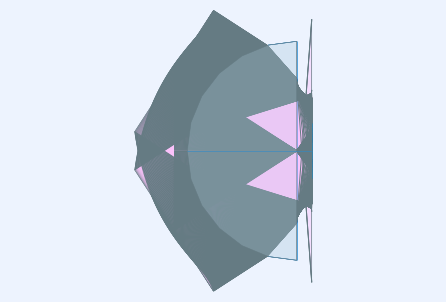

In [4]:
## 8.0mm Diameter, N-BK7 Half-Ball Lens
lens_codv_name = "CODV_45936.seq"
if (not os.path.isfile(lens_codv_name)):
    print('File', lens_codv_name, 'does not exist, downloading from EdmundOptics website')
    cmd = 'wget https://www.edmundoptics.com/document/download/471193 -O ' + lens_codv_name
    os.system(cmd)
aoa_sweep_lim    = 33.0
aoa_sweep_res    = 0.25
aoa_list         = np.arange(-aoa_sweep_lim, aoa_sweep_lim + aoa_sweep_res, aoa_sweep_res).tolist()

opm, sm, osp, pm = define_optics(lens_codv_name, detector_stop_distance, aperture_stop_diameter, aoa_list)

sm.list_model()
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=True, do_paraxial_layout=False).plot()

In [5]:
rl = get_ray_lists(20, 4, osp, opm, draw_spots=False)

100%|██████████| 265/265 [00:15<00:00, 17.27it/s]


100%|██████████| 265/265 [00:01<00:00, 139.50it/s]


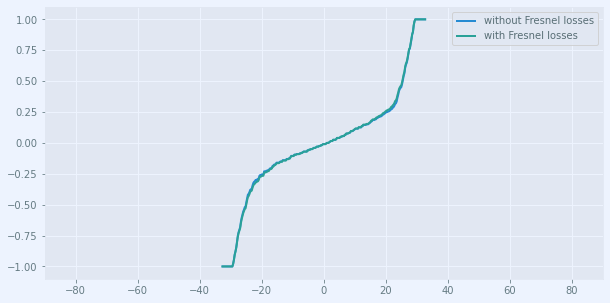

In [6]:
a, b, total = calc_fqrx(osp, rl, aoa_list, sm.rndx, with_fresnel=True, draw_fqrx=True)

In [7]:
print("difference between response w/ and w/o fresnel losses: \n\n", 
      np.round(1000*100*np.mean(np.divide(np.asarray(a)-np.asarray(b), np.asarray(a))))/1000, '%')

difference between response w/ and w/o fresnel losses: 

 -inf %


save to npz

In [ ]:
s = np.zeros((len(aoa_list), 2))
s[:,0] = np.asarray(aoa_list)
s[:,1] = np.asarray(b)

np.savez('../qrx_hemispherical.npz', 
         f_QRX = s,
         tia_gamma            = gamma,
         tia_R_F              = R_F,
         tia_shot_P_r_factor  = shot_P_r_factor,
         tia_shot_I_bg_factor = shot_I_bg_factor,
         tia_thermal_factor1  = thermal_factor1,
         tia_thermal_factor2  = thermal_factor2,
         detecting_area = aperture_stop_diameter)

### 2- Quad + PlanoConvex Lens, f=90.0mm


#### Specify electrical parameters

In [2]:
electron  = 01.60e-19;      # [C]   
boltzmann = 01.38e-23;      # [J/K] 
gamma     = 00.50;          # [A/W]
gm        = 30.00e-3;       # [S]   
bandwidth = 10.00e6;        # [Hz]  
C_T       = 44.45e-12;      # [F]
R_F       = 02.84e3;        # [Ohm], computed from G, see SonerColeri TVT article
capGamma  = 01.50;          # []
I_B2      = 05.62e-1;       # []
I_B3      = 08.68e-2;       # []

## noise factors
shot_P_r_factor   = 2*electron*gamma*bandwidth;                                     # [A^2/W] -> [A^2 when *P_r]
shot_I_bg_factor  = 2*electron*I_B2*bandwidth;                                      # [A]     -> [A^2 when *I_bg]
thermal_factor1   = 4*boltzmann*I_B2*bandwidth/R_F;                                 # [A^2/K] -> [A^2 when *T]
thermal_factor2   = 4*boltzmann*I_B3*(bandwidth**3)*capGamma*((2*np.pi*C_T)**2)/gm; # [A^2/K] -> [A^2 when *T]

#### Specify optical parameters and do ray optics simulations to obtain $f_{QRX}$

In [3]:
aperture_stop_diameter = 6.3
detector_stop_distance = 1.9 # "d_X"

             r            t        medium     mode   zdr      sd
 Obj:     0.000000  1.00000e+13       air             1  1.7321e+13
67149:    46.510000      2.00000     N-BK7             1      4.0500
Stop:     0.000000      1.90000       air             1      3.6342
 Img:     0.000000      0.00000                       1      5.2958


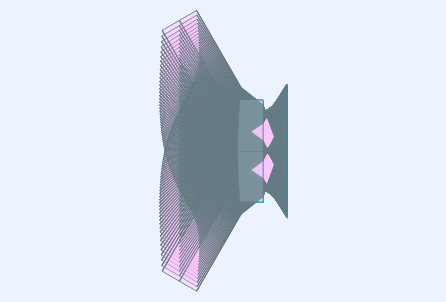

In [4]:
## 9.0mm Dia. x 90.0mm FL, Uncoated, Plano-Convex Lens
lens_codv_name = "CODV_67149.seq"
if (not os.path.isfile(lens_codv_name)):
    print('File', lens_codv_name, 'does not exist, downloading from EdmundOptics website')
    cmd = 'wget https://www.edmundoptics.com/document/download/474580 -O ' + lens_codv_name
    os.system(cmd)
aoa_sweep_lim    = 60.0
aoa_sweep_res    = 1.00
aoa_list         = np.arange(-aoa_sweep_lim, aoa_sweep_lim + aoa_sweep_res, aoa_sweep_res).tolist()

opm, sm, osp, pm = define_optics(lens_codv_name, detector_stop_distance, aperture_stop_diameter, aoa_list)

sm.list_model()
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=True, do_paraxial_layout=False).plot()

In [5]:
rl = get_ray_lists(150, 4, osp, opm, draw_spots=False)

100%|██████████| 121/121 [06:18<00:00,  3.13s/it]


100%|██████████| 121/121 [01:17<00:00,  1.56it/s]


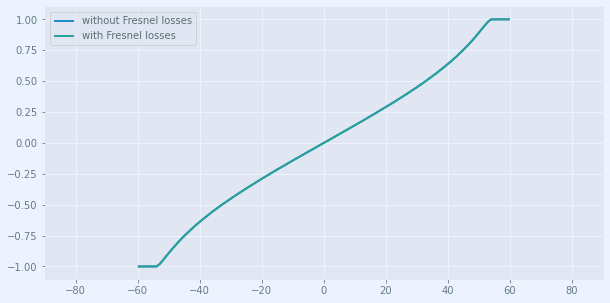

In [6]:
a, b, total = calc_fqrx(osp, rl, aoa_list, sm.rndx, with_fresnel=True, draw_fqrx=True)

In [7]:
print("difference between response w/ and w/o fresnel losses: \n\n", 
      np.round(1000*100*np.mean(np.divide(np.asarray(a)-np.asarray(b), np.asarray(a))))/1000, '%')

difference between response w/ and w/o fresnel losses: 

 inf %


save to npz

In [8]:
s = np.zeros((len(aoa_list), 2))
s[:,0] = np.asarray(aoa_list)
s[:,1] = np.asarray(b)

np.savez('../qrx_planoconvex.npz', 
         f_QRX = s,
         tia_gamma            = gamma,
         tia_R_F              = R_F,
         tia_shot_P_r_factor  = shot_P_r_factor,
         tia_shot_I_bg_factor = shot_I_bg_factor,
         tia_thermal_factor1  = thermal_factor1,
         tia_thermal_factor2  = thermal_factor2,
         detecting_area = aperture_stop_diameter)